In [6]:
# import numpy as np
# from PySDM.physics.constants import si
# from PySDM_examples.Luettmer_homogeneous_freezing.commons import run_simulations, hom_pure_droplet_freezing_backend, hom_pure_droplet_freezing_standard_setup
# from PySDM_examples.Luettmer_homogeneous_freezing.simulation import Simulation
# from PySDM_examples.Luettmer_homogeneous_freezing.settings import Settings
# from PySDM_examples.Luettmer_homogeneous_freezing import plot
# from importlib import reload
# from matplotlib import pyplot
# from open_atmos_jupyter_utils import show_plot

In [7]:
import numpy as np
from PySDM.physics.constants import si
from commons import run_simulations, hom_pure_droplet_freezing_backend, hom_pure_droplet_freezing_standard_setup
from simulation import Simulation
from settings import Settings
import plot
from importlib import reload
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [21]:
""" General settings """
hom_freezing_types     = [  "KoopMurray2016", "Spichtinger2023" ]
hom_freezing_types_all = [  "KoopMurray2016", "Spichtinger2023", "Koop2000"  ]
vertical_updrafts = np.geomspace(0.2,10,num=9) * si.meter / si.second
number_concentrations = np.geomspace(100, 20000, num=10) / si.cm ** 3

backends = hom_pure_droplet_freezing_backend()
standard = hom_pure_droplet_freezing_standard_setup()

In [9]:

""" High output step reference simulations """
setting_dict = {
            **standard,
            "backend": backends["KoopMurray2016"],
            "hom_freezing": "KoopMurray2016",
            "w_updraft": 10.,
            "deposition_enable": False,
            "n_output": 1
            }
KoopMurray2016_reference_high_w_simulation = run_simulations(setting_dict)
setting_dict = {
            **standard,
            "backend": backends["Spichtinger2023"],
            "hom_freezing": "Spichtinger2023",
            "w_updraft": 10.,
            "deposition_enable": False,
            "n_output": 1,
            "dz": 0.1,
            }
Spichtinger2023_reference_high_w_simulation = run_simulations(setting_dict)
setting_dict = {
            **standard,
            "backend": backends["KoopMurray2016"],
            "hom_freezing": "KoopMurray2016",
            "w_updraft": 0.2,
            "deposition_enable": False,
            "n_output": 1,
            "dz": 0.1,
            }
KoopMurray2016_reference_low_w_simulation = run_simulations(setting_dict)

Setting up simulation for KoopMurray2016 with wpdraft=10.0 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for Spichtinger2023 with wpdraft=10.0 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.2 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated


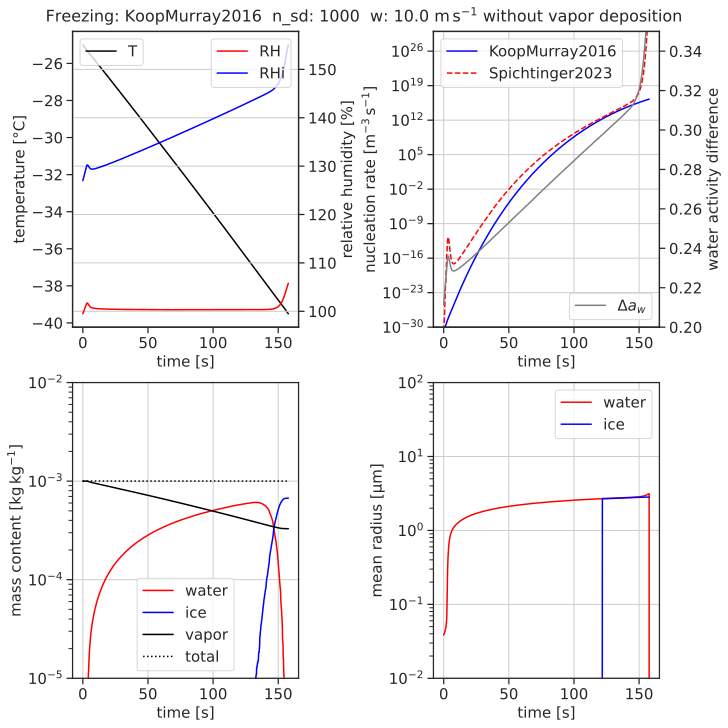

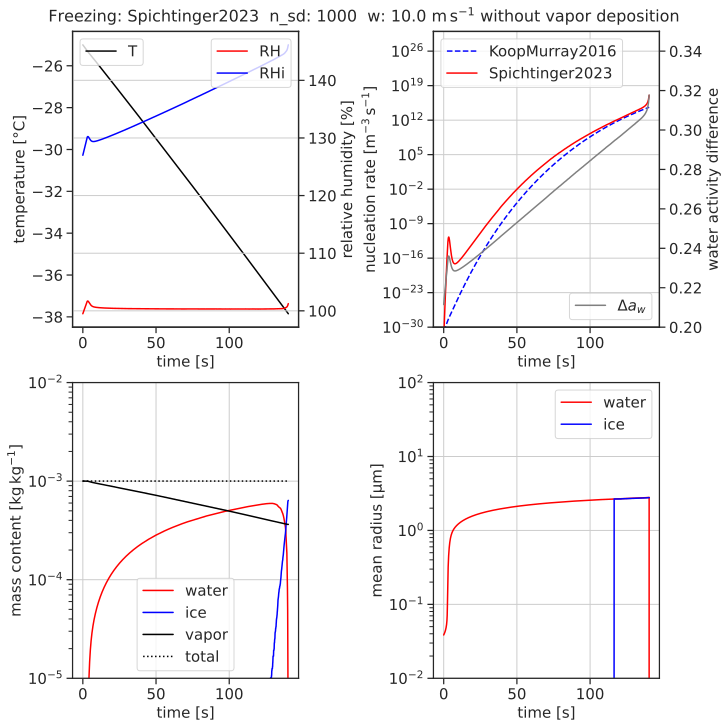

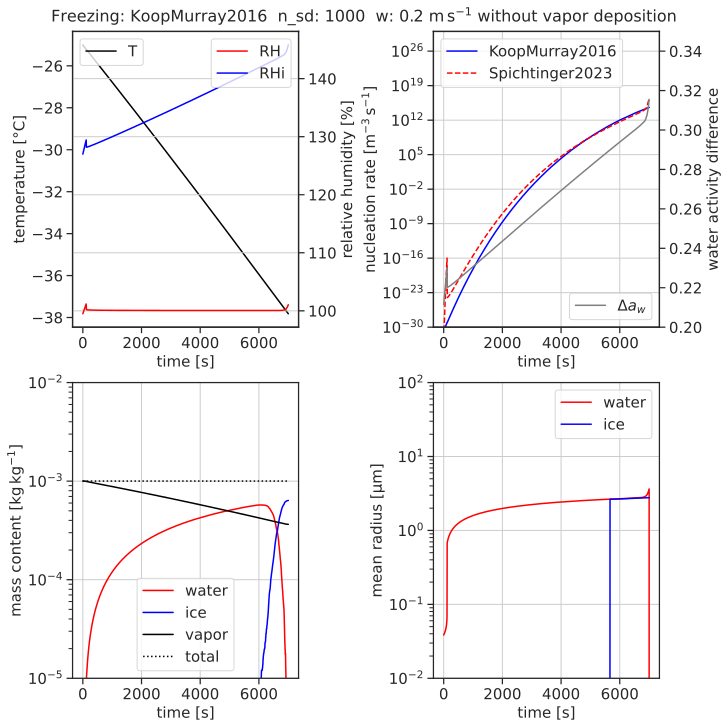

In [20]:
reload(plot)
plot.plot_thermodynamics_and_bulk(KoopMurray2016_reference_high_w_simulation, " without vapor deposition")
show_plot("fig_KM16_high_w_no_dep")
plot.plot_thermodynamics_and_bulk(Spichtinger2023_reference_high_w_simulation, " without vapor deposition")
show_plot("fig_SP23_high_w_no_dep")
plot.plot_thermodynamics_and_bulk(KoopMurray2016_reference_low_w_simulation, " without vapor deposition")
show_plot("fig_KM16_low_w_no_dep")

In [11]:
""" Simulations for n_sd ensemble without deposition """
nsd_ensemble_simulations =[]
number_of_nsd = (1e1, 1e2, 1e3)
for hom_freezing_type in hom_freezing_types:
    for n_sd in number_of_nsd:
        setting_dict = {
            **standard,
            "n_sd": int(n_sd),
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "number_of_ensemble_runs": 5,
            "deposition_enable": False,
            }
        nsd_ensemble_simulations.append( run_simulations(setting_dict) )

Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=100 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10

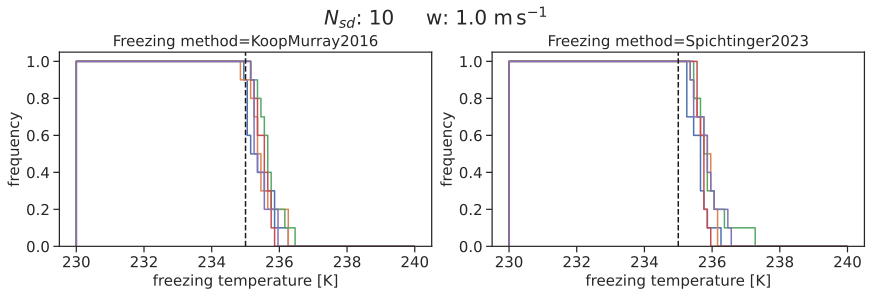

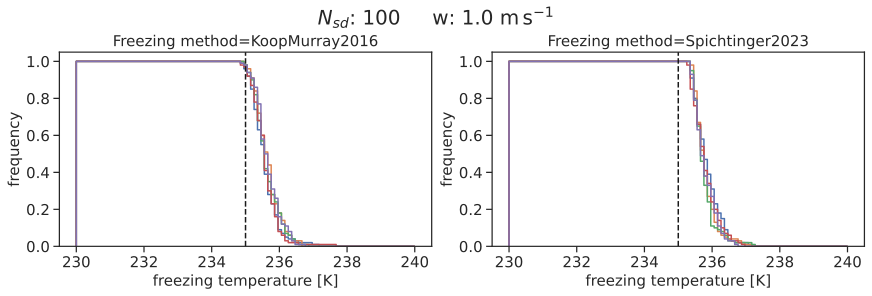

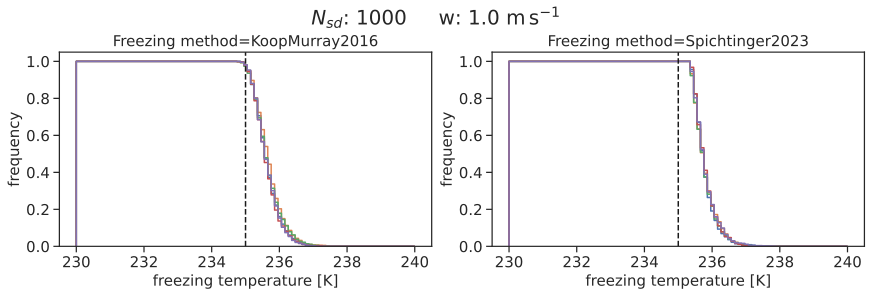

In [32]:
""" Plots for n_sd ensemble without deposition """
reload(plot)
for n_sd in number_of_nsd:
    fig, axs = pyplot.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    fig.suptitle(r"$N_{sd}$: "+"{}".format(int(n_sd))+"     w: "+str(standard["w_updraft"])+r" $\mathrm{m \, s^{-1}}$",fontsize=20)
    axs = axs.ravel()
    i = 0
    for simulation in nsd_ensemble_simulations:
        if simulation["settings"]["n_sd"] == n_sd and simulation["settings"]["w_updraft"] == standard["w_updraft"]:
            axs[i] = plot.plot_freezing_temperatures_histogram(axs[i], simulation)
            i += 1
    show_plot("n_sd_"+str(n_sd)+"_ensemble_without_deposition")

In [13]:
""" Updraft ensemble simulations without deposition  """
simulations_ensemble_no_deposition = []
for hom_freezing_type in hom_freezing_types:
    for updraft in vertical_updrafts:
        setting_dict = {
            **standard,
            "w_updraft": updraft  * si.meter / si.second,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
            }
        simulations_ensemble_no_deposition.append( run_simulations(setting_dict) )

Setting up simulation for KoopMurray2016 with wpdraft=0.2 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.32613788179066194 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.5318295896944989 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.8672488792828036 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.4142135623730951 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=2.306143078159937 and n_sd=1000 and n_dv=4999999999.999999
Starting simulation...
all particles froz

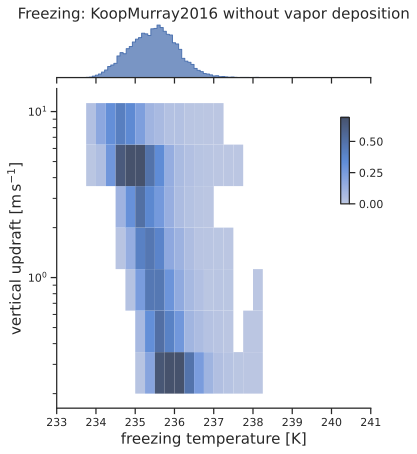

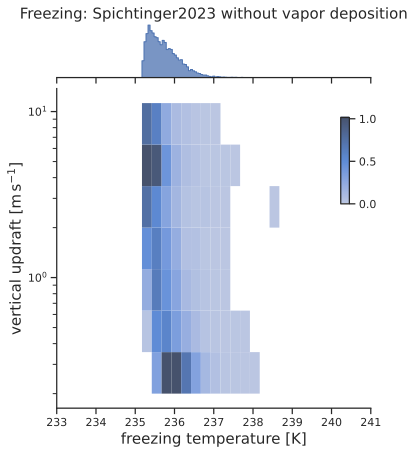

In [41]:
""" Plot ensemble simulations without deposition  """
reload(plot)
for hom_freezing_type in hom_freezing_types:

    histogram_data_dict = {}

    histogram_data_dict["hom_freezing_type"] = hom_freezing_type
    histogram_data_dict["T_frz_histogram_list"] = []
    histogram_data_dict["w_updraft_histogram_list"] = []

    for i, updraft in enumerate(vertical_updrafts):
        for simulation in simulations_ensemble_no_deposition:
            if (simulation["settings"]["w_updraft"] == updraft
                    and simulation["settings"]["hom_freezing"] == hom_freezing_type):
                output = simulation["ensemble_member_outputs"][0]
                T_frz = output["T_frz"]
                histogram_data_dict["T_frz_histogram_list"].extend( T_frz )
                histogram_data_dict["w_updraft_histogram_list"].extend( np.full_like(T_frz, updraft) )

    plot.plot_freezing_temperatures_2d_histogram_seaborn(histogram_data_dict, title_add = " without vapor deposition")
    show_plot(hom_freezing_type+"_updraft_ensemble_no_deposition")

In [34]:
""" Simulations for CCN concentration histogram  """
simulations_ccn_concentration_ensemble = []

for hom_freezing_type in hom_freezing_types:
    for n_dv in number_concentrations:
        setting_dict = {
            **standard,
            "N_dv_droplet_distribution": n_dv,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
        }
        simulations_ccn_concentration_ensemble.append(run_simulations(setting_dict))

Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=99999999.99999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=180164823.06544116
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=324593634.7020169
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=584803547.6425728
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=1053610276.8906642
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=1898235091.1593704
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1

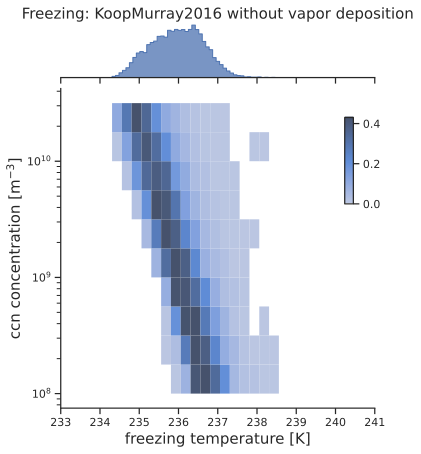

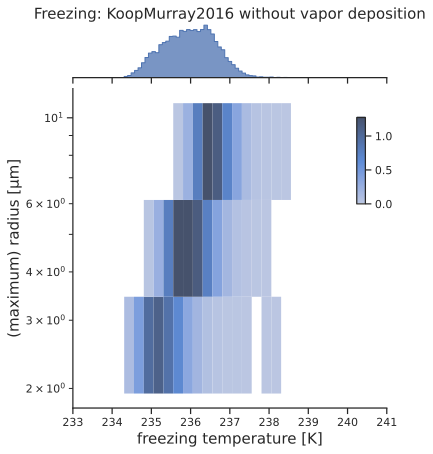

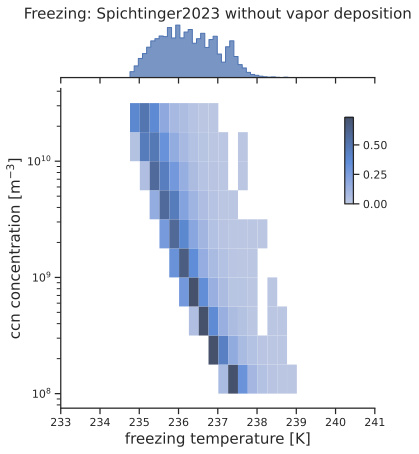

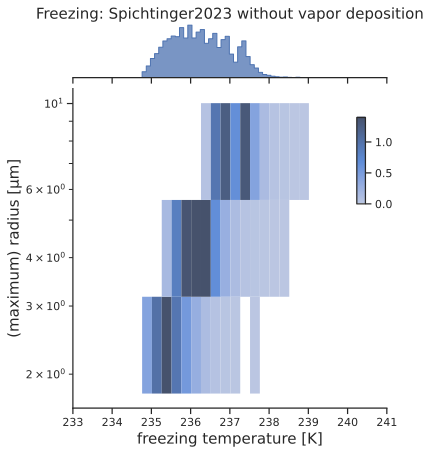

In [42]:
for hom_freezing_type in hom_freezing_types:

    histogram_data_ccn_concentration_ensemble = {}
    histogram_data_ccn_concentration_ensemble["hom_freezing_type"] = hom_freezing_type

    histogram_data_ccn_concentration_ensemble["T_frz_histogram_list"] = []
    histogram_data_ccn_concentration_ensemble["n_ccn_histogram_list"] = []
    histogram_data_ccn_concentration_ensemble["rc_max_histogram_list"] = []

    for n_ccn in number_concentrations:
        for simulation in simulations_ccn_concentration_ensemble:
            if (simulation["settings"]["hom_freezing"] == hom_freezing_type
                    and simulation["settings"]["N_dv_droplet_distribution"] == n_ccn):
                output = simulation["ensemble_member_outputs"][0]
                T_frz = np.asarray(output["T_frz"])
                rc = np.asarray(output["rs"])
                histogram_data_ccn_concentration_ensemble["T_frz_histogram_list"].extend( T_frz )
                histogram_data_ccn_concentration_ensemble["n_ccn_histogram_list"].extend( np.full_like(T_frz, n_ccn) )
                histogram_data_ccn_concentration_ensemble["rc_max_histogram_list"].extend( np.full_like(T_frz, np.amax(rc)) )

    plot.plot_freezing_temperatures_2d_histogram_seaborn(histogram_data_ccn_concentration_ensemble, title_add=" without vapor deposition")
    show_plot(hom_freezing_type+"_ccn_ensemble_without_deposition")
    del histogram_data_ccn_concentration_ensemble["n_ccn_histogram_list"]
    plot.plot_freezing_temperatures_2d_histogram_seaborn(histogram_data_ccn_concentration_ensemble, title_add=" without vapor deposition")
    show_plot(hom_freezing_type+"_radius_ensemble_without_deposition")